In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib

import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import Activation, BatchNormalization
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers import LeakyReLU, ReLU
from keras.layers import concatenate, add
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array, load_img, array_to_img

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

PATH = 'dataset/exp-data'
STORE_NAME = 'SRResNet-DRAGAN' # name of folders
store_image_dir = '{}-images'.format(STORE_NAME) # folder to store images for NN

# data variables
IMG_SIZE = 128
CHANNELS = 3
NOISE_DIM = 100

# training variables
EPOCHS = 300
BATCH_SIZE = 16

# hyperparameter tuning 
MOMENTUM = 0.8
EPSILON = 0.00005
LEARNING_RATE=0.0002
BETA1 = 0.5

# create numpy array (tensor) for the dataset
train_images = np.ndarray(shape=(6000, IMG_SIZE, IMG_SIZE, CHANNELS), dtype=np.float32)

for i, img in enumerate(os.listdir(PATH)):
    if i >= 6000:
        break
    # using keras image preprocessing package convert the images into a matrix
    image = load_img(PATH + '/' + img)
    x = img_to_array(image)
    
    # add the matrices into the tensor
    train_images[i] = x

train_images.shape

Using TensorFlow backend.


(6000, 128, 128, 3)

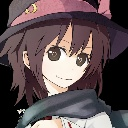

In [2]:
test = array_to_img(train_images[100])
test

In [3]:
train_images = train_images/127.5 - 1 # normalize data to -1 to 1
len(train_images[0])

128

In [4]:
print("Keras : ", keras.__version__)
# test channels first or channels last
print("\t data_format : ", keras.backend.image_data_format())
print("Tensorflow : ", tf.__version__)
device_lib.list_local_devices()

Keras :  2.2.4
	 data_format :  channels_last
Tensorflow :  1.13.1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9435029771406275664, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2219101388
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2105838734345624106
 physical_device_desc: "device: 0, name: GeForce GTX 1060 3GB, pci bus id: 0000:1d:00.0, compute capability: 6.1"]

## Building the Generator

In [5]:
# building residual block
def residual_block(inputs):
    # k3n64s1
    X = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', use_bias=False)(inputs)
    X = BatchNormalization(axis=-1)(X)
    X = ReLU()(X)
    X = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', use_bias=False)(X)
    X = BatchNormalization(axis=-1)(X)
    return add([X, inputs])

# using UpSampling
def upsample_block(X):
    # k3n256s1
    X = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', use_bias=False)(X)
#     print('------------0',X)
    X = UpSampling2D(size=(2, 2))(X)
#     print('------------1',X)
    X = BatchNormalization(axis=-1)(X)
    X = ReLU()(X)
    return X

In [6]:
z_input = Input(shape=(NOISE_DIM,))
X = Dense(64*16*16)(z_input)
# print(X)
X = Reshape((16,16,64))(X)
# print(X)
X = BatchNormalization(axis=-1)(X)
X = ReLU()(X)
X_shortcut = X

# add 16 residual blocks
for _ in range(16):
    X = residual_block(X)
#     print(X)

X = BatchNormalization(axis=-1)(X)
X = ReLU()(X)

# skip connection
X = add([X, X_shortcut])
# print(X)

# 3 upsampling blocks
X = upsample_block(X)
# print(X)
X = upsample_block(X)
# print(X)
X = upsample_block(X)
# print(X)

output = Conv2D(3, kernel_size=(9,9), strides=(1,1), padding='same', activation='tanh',use_bias=False)(X)
# print(output)
generator = Model(inputs=z_input, outputs=output)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16384)        1654784     input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 16, 16, 64)   0           dense_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 64)   256         reshape_1[0][0]                  
__________________________________________________________________________________________________
re_lu_1 (R

re_lu_7 (ReLU)                  (None, 16, 16, 64)   0           batch_normalization_12[0][0]     
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 16, 16, 64)   36864       re_lu_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 16, 16, 64)   256         conv2d_12[0][0]                  
__________________________________________________________________________________________________
add_6 (Add)                     (None, 16, 16, 64)   0           batch_normalization_13[0][0]     
                                                                 add_5[0][0]                      
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 16, 16, 64)   36864       add_6[0][0]                      
__________

batch_normalization_25 (BatchNo (None, 16, 16, 64)   256         conv2d_24[0][0]                  
__________________________________________________________________________________________________
add_12 (Add)                    (None, 16, 16, 64)   0           batch_normalization_25[0][0]     
                                                                 add_11[0][0]                     
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 16, 16, 64)   36864       add_12[0][0]                     
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 16, 16, 64)   256         conv2d_25[0][0]                  
__________________________________________________________________________________________________
re_lu_14 (ReLU)                 (None, 16, 16, 64)   0           batch_normalization_26[0][0]     
__________

up_sampling2d_3 (UpSampling2D)  (None, 128, 128, 256 0           conv2d_35[0][0]                  
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 128, 128, 256 1024        up_sampling2d_3[0][0]            
__________________________________________________________________________________________________
re_lu_21 (ReLU)                 (None, 128, 128, 256 0           batch_normalization_37[0][0]     
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 128, 128, 3)  62208       re_lu_21[0][0]                   
Total params: 4,235,520
Trainable params: 4,229,632
Non-trainable params: 5,888
__________________________________________________________________________________________________


## Build the Discriminator

In [8]:
# 2 BLOCKS
# k3n32s1 * 2
def first_disc_res_block(inputs):
    X_shortcut = inputs
    X = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same',use_bias=False)(inputs)
    X = LeakyReLU()(X)
    X = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same',use_bias=False)(X)
    X = add([X, X_shortcut])
    X = LeakyReLU()(X)
    return X

# 2 BLOCKS
# k3n64s1 * 2
def second_disc_res_block(inputs):
    X_shortcut = inputs
    X = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same',use_bias=False)(inputs)
    X = LeakyReLU()(X)
    X = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same',use_bias=False)(X)
    X = LeakyReLU()(X)
    X = add([X, X_shortcut])
    X = LeakyReLU()(X)
    return X

# 2 BLOCKS
# k3n128s1 * 2
def third_disc_res_block(inputs):
    X_shortcut = inputs
    X = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same',use_bias=False)(inputs)
    X = LeakyReLU()(X)
    X = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same',use_bias=False)(X)
    X = LeakyReLU()(X)
    X = add([X, X_shortcut])
    X = LeakyReLU()(X)
    return X

# 2 BLOCKS
# k3n256s1 * 2
def forth_disc_res_block(inputs):
    X_shortcut = inputs
    X = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same',use_bias=False)(inputs)
    X = LeakyReLU()(X)
    X = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same',use_bias=False)(X)
    X = LeakyReLU()(X)
    X = add([X, X_shortcut])
    X = LeakyReLU()(X)
    return X

# 2 BLOCKS
# k3n512s1 * 2
def fifth_disc_res_block(inputs):
    X_shortcut = inputs
    X = Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same',use_bias=False)(inputs)
    X = LeakyReLU()(X)
    X = Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same',use_bias=False)(X)
    X = LeakyReLU()(X)
    X = add([X, X_shortcut])
    X = LeakyReLU()(X)
    return X

In [9]:
image_input = Input(shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
X = Conv2D(32, kernel_size=(4,4), strides=(2,2), padding='same',use_bias=False)(image_input)
X = LeakyReLU()(X)

X = first_disc_res_block(X)
X = first_disc_res_block(X)
X = Conv2D(64, kernel_size=(4,4), strides=(2,2), padding='same',use_bias=False)(X)
X = LeakyReLU()(X)

X = second_disc_res_block(X)
X = second_disc_res_block(X)
X = Conv2D(128, kernel_size=(4,4), strides=(2,2), padding='same',use_bias=False)(X)
X = LeakyReLU()(X)

X = third_disc_res_block(X)
X = third_disc_res_block(X)
X = Conv2D(256, kernel_size=(3,3), strides=(2,2), padding='same',use_bias=False)(X)
X = LeakyReLU()(X)

X = forth_disc_res_block(X)
X = forth_disc_res_block(X)
X = Conv2D(512, kernel_size=(3,3), strides=(2,2), padding='same',use_bias=False)(X)
X = LeakyReLU()(X)

X = fifth_disc_res_block(X)
X = fifth_disc_res_block(X)
X = Conv2D(1024, kernel_size=(3,3), strides=(2,2), padding='same',use_bias=False)(X)
X = LeakyReLU()(X)

X = Flatten()(X)
pred = Dense(1, activation='sigmoid')(X)
discriminator = Model(inputs=image_input, outputs=pred)

In [10]:
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 64, 64, 32)   1536        input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           conv2d_37[0][0]                  
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 64, 64, 32)   9216        leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
leaky_re_l

conv2d_51 (Conv2D)              (None, 16, 16, 128)  147456      leaky_re_lu_17[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_18 (LeakyReLU)      (None, 16, 16, 128)  0           conv2d_51[0][0]                  
__________________________________________________________________________________________________
add_23 (Add)                    (None, 16, 16, 128)  0           leaky_re_lu_18[0][0]             
                                                                 leaky_re_lu_16[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_19 (LeakyReLU)      (None, 16, 16, 128)  0           add_23[0][0]                     
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 8, 8, 256)    294912      leaky_re_lu_19[0][0]             
__________

In [11]:
# define optimizer
adam = Adam(lr=LEARNING_RATE, beta_1=BETA1)

# generator = Generator()
# discriminator = Discriminator()

# compile the discriminator
discriminator.compile(loss='binary_crossentropy', 
              optimizer=adam,
             metrics=['accuracy'])

discriminator.trainable = False
# generator noise
z_input = Input(shape=(NOISE_DIM,))
fake_image = generator(z_input)
fake_pred = discriminator(fake_image)

# compile generator and discriminator
# training generator to fool discriminator
gan = Model(inputs=z_input, outputs=fake_pred)
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [12]:
# try:
#     os.makedirs(store_image_dir)
# except FileExistsError:
#     pass

def show_samples(epoch, sample_images, dim=(4,4), figsize=(8,8)):
    plt.figure(figsize=figsize)
    for i, img in enumerate(sample_images):
        img = ((img+1.0)*127.5).astype('int')
        image = array_to_img(img)
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
#     plt.savefig('{}/epoch {}.png'.format(store_image_dir, epoch))
    plt.show()
    plt.close()

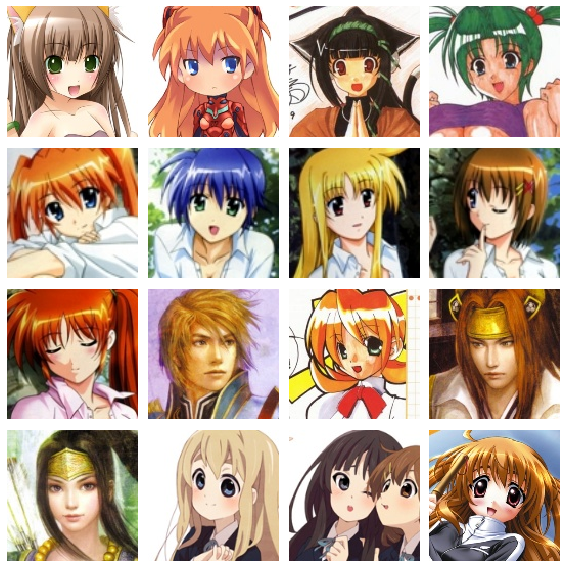

In [13]:
show_samples(0,train_images[:16])

In [14]:
losses = []

def train(epochs, batch_size=64,step=1):
    # training of (6000,128,128,3)
    m = train_images.shape[0] # number of training examples
    batch_count = m/batch_size # number of minibatches
    print ('Epochs:', epochs)
    print ('Batch size:', batch_size)
    print ('Batches per epoch:', batch_count)
        
    for e in range(step, epochs+1):

        # minibatches without the end case
        for _ in tqdm(np.arange(batch_count)):
            # random m samples from gaussian distribution
            z_batch = np.random.uniform(-1, 1, size=(batch_size, NOISE_DIM))
            # getting m training samples
            x_batch = train_images[np.random.randint(0, train_images.shape[0], size=batch_size)]

            # generating m images from random normal distribution sampling
            generated_images = generator.predict(z_batch)
            
            # creating labels for real and fake data for training
            real_labels = np.ones((batch_size, 1))
            fake_labels = np.zeros((batch_size, 1))

            # one-sided label smoothing
            # https://github.com/soumith/ganhacks#6-use-soft-and-noisy-labels
            real_labels[:] = 0.9

            # train discriminator
            discriminator.trainable = True
            dloss_real = discriminator.train_on_batch(x_batch, real_labels)
            dloss_fake = discriminator.train_on_batch(generated_images, fake_labels)
            dloss = 0.5 * np.add(dloss_real, dloss_fake)

            # train generator
            discriminator.trainable = False
            gloss = gan.train_on_batch(z_batch, real_labels)

        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (e, dloss[0], 100*dloss[1], gloss))

        if e == step or e % 5 == 0:
            z_batch = np.random.uniform(-1, 1, size=(batch_size, NOISE_DIM))
            generated_images = generator.predict(z_batch)
            show_samples(e, generated_images[:16])

        if e % 10 == 0 and e is not step:
            print('Model saved for epoch {}'.format(e))
            saver.save(sess,'model/{}-model'.format(STORE_NAME),global_step=e)

        losses.append([dloss,gloss])

In [15]:
train(EPOCHS, batch_size=BATCH_SIZE)

Epochs: 300
Batch size: 16
Batches per epoch: 375.0


  0%|          | 0/375 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


ResourceExhaustedError: OOM when allocating tensor with shape[16,256,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_1/Adam/gradients/model_1/conv2d_36/convolution_grad/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
# import csv
# with open('losses/dcgan-improved-losses.csv', 'w') as csvFile:
#     writer = csv.writer(csvFile)
#     writer.writerows(losses)